# **Tensorflow2.X学习（一） — Keras基础应用（MNIST手写数字图像识别）**

tensorflow：2.6.0
---
python：3.7.11
---



**一、版本检查**

In [26]:
tf.__version__

'2.6.0'

In [2]:
import platform
print(platform.python_version())

3.7.11


**二.MNIST的数据查看**

1.相关包导入

In [3]:
import tensorflow as tf                 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

2.读取MNIST数据。

In [4]:
#分别读入MNIST数据集的训练集数据和测试集数据
(X_train_image,y_train_label),(X_test_image,y_test_label) = tf.keras.datasets.mnist.load_data()

3.打印MNIST数据的尺寸大小

In [5]:
print(len(X_train_image))
print(len(X_test_image))
print(X_train_image.shape)

60000
10000
(60000, 28, 28)


60000张图像是训练集的数目，10000张则是测试集的数目，（60000，28，28）中的60000代表的是Batch_size, 28和28分别代表一张图像的长和宽。

4.定义函数显示数字的图像

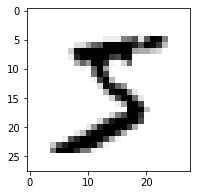

In [6]:
def plot_image(image):
    fig=plt.gcf()    #图表生成
    fig.set_size_inches(3,3)  #设置图表大小
    plt.imshow(image,cmap='binary') #以黑白灰度显示图片
    plt.show()    #开始绘图
 
plot_image(X_train_image[0]) #显示一张图片

5.为了更加方便查看图像、标签及预测结果之间对应的关系，我们定义一个函数来显示。


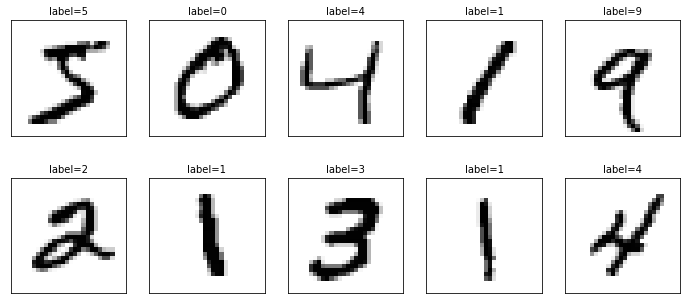

In [7]:
def plot_image_labels_prediction(images,labels,prediction,idx,nums=10):
    fig = plt.gcf() 
    fig.set_size_inches(12,14)  #设置图表大小
    if nums>25: nums=25 #最多显示25张图像
    for i in range(0,nums):
        ax = plt.subplot(5,5,1+i) #子图生成
        ax.imshow(images[idx],cmap='binary') #idx是为了方便索引所要查询的图像
        title = 'label=' + str(labels[idx]) #定义title方便图像结果对应
        if(len(prediction)>0): #如果有预测图像，则显示预测结果
            title += 'prediction='+ str(prediction[idx])
        ax.set_title(title,fontsize=10) #设置图像title
        ax.set_xticks([]) #无x刻度
        ax.set_yticks([]) #无y刻度
        idx+=1
    plt.show()
 
plot_image_labels_prediction(X_train_image,y_train_label,[],0,10) #显示前10张的图像
#下图为最后一行命令的显示结果：

**三、MNIST的数据预处理**

1.将image转化为一维向量, 转化过程是图像大小相乘，结果为：28x28 = 784, 以便于能作为神经网络的第一层输入。



In [8]:
X_train = X_train_image.reshape(60000,784).astype('float32') #二维转一维
X_test = X_test_image.reshape(10000,784).astype('float32')

2.对图像数据进行归一化。归一化是必要操作，可以提高准确率。原因是如果没有归一化那么图像的数据值是0-255，不同的图像之间的值差异很大，在训练过程中，小的值很容易被忽略。因此我们需要对数据进行缩放，常见的一种方法是将数据的值压缩到(0,1)区间内，在本例中，直接将数据除以255即可。

In [9]:
X_train_normalize = X_train/255 #归一化
X_test_normalize = X_test/255

3.对数据标签进行One-hot编码（独热编码），我们都知道数字识别的结果是0-9，但为了满足神经网络的最后一层的10个神经元输出，我们需要将数字转换为二进制的10个0和1的组合，具体可看下面代码例子，第一个为数据的原标签，第二个是One-hot编码后的标签。

In [10]:
y_train_label[:5] #显示前5个图像的对应标签数字

array([5, 0, 4, 1, 9], dtype=uint8)

之后大家可以直接调用keras的utils中的to_categorical函数进行直接数字编码。

In [11]:
y_TrainOneHot = tf.keras.utils.to_categorical(y_train_label) #One-Hot编码
y_TestOneHot = tf.keras.utils.to_categorical(y_test_label)
 
y_TrainOneHot[0:5] #显示前5个数据编码后的结果

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

上图为编码结果，其中1在第几个位置则代表了数字的大小是多少。

**四.模型的搭建**


1.建立线性堆叠模型Sequential，使用它我们可以搭建出很多复杂的神经网络模型，后面的层就犹如叠面包一样一层一层通过add指令叠加上去就好了，十分方便。



In [12]:
model = tf.keras.models.Sequential() # 调用Sequential模型


2.不断叠加层上去，Dense层是全连接层，指的是神经前后前后两层神经元中两两都有互相连接，而Dropout的层的作用是为了防止过拟合（过拟合概念可自行查询），随机使多少比例的神经元失活，等于是断了之间的连接关系。



In [13]:
#units是该层神经元数量，input_dim是数据输入大小，kernel_initializer=normal指的是用正态分布来初始化神经元的权重和偏差，activation指的是激活函数
model.add(layers.Dense(units=256,input_dim=784,kernel_initializer='normal',activation='relu')) 
model.add(layers.Dropout(0.5)) #使50%的神经元失活
#最终输出是0-9，因此是10个神经元，softmax激活函数可以将输出转化为预测每个数字的概率
model.add(layers.Dense(units=10,kernel_initializer='normal',activation='softmax'))

3.通过summary我们可以查看我们刚才搭建的模型的概要。



In [14]:
print(model.summary()) #显示模型信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


大家可以从上图看到我们刚建立的模型信息，其中Param指的是该层神经元总的参数数量，具体的计算公式是 Param=（上一层神经元数量）x（本层神经元数量）+（本层神经元数量）

比如图中的200960是由（784x256+256）得到的。

**五.模型的训练**


1.在训练模型之间，我们需要定义一些训练的相关参数，比如优化器、损失函数和评估模型的方式。



In [15]:
#loss这里采用的交叉熵损失，优化器采用的是adam优化器，评估方式为准确率
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2.开始训练，其中validation_split是将原数据集划分一部分为验证集，epoch是训练次数，batch_size是每一批训练的数据量，verbose=2代表显示所有训练过程。



In [16]:
train_history = model.fit(x=X_train_normalize,y=y_TrainOneHot,validation_split=0.2,epochs=10,batch_size=200,verbose=2) 

Epoch 1/10
240/240 - 2s - loss: 0.5344 - accuracy: 0.8462 - val_loss: 0.2282 - val_accuracy: 0.9365
Epoch 2/10
240/240 - 2s - loss: 0.2522 - accuracy: 0.9273 - val_loss: 0.1673 - val_accuracy: 0.9544
Epoch 3/10
240/240 - 2s - loss: 0.1947 - accuracy: 0.9434 - val_loss: 0.1360 - val_accuracy: 0.9620
Epoch 4/10
240/240 - 2s - loss: 0.1611 - accuracy: 0.9531 - val_loss: 0.1191 - val_accuracy: 0.9658
Epoch 5/10
240/240 - 2s - loss: 0.1435 - accuracy: 0.9577 - val_loss: 0.1053 - val_accuracy: 0.9689
Epoch 6/10
240/240 - 2s - loss: 0.1241 - accuracy: 0.9632 - val_loss: 0.0983 - val_accuracy: 0.9698
Epoch 7/10
240/240 - 2s - loss: 0.1110 - accuracy: 0.9671 - val_loss: 0.0910 - val_accuracy: 0.9732
Epoch 8/10
240/240 - 2s - loss: 0.1017 - accuracy: 0.9693 - val_loss: 0.0899 - val_accuracy: 0.9730
Epoch 9/10
240/240 - 2s - loss: 0.0939 - accuracy: 0.9717 - val_loss: 0.0835 - val_accuracy: 0.9747
Epoch 10/10
240/240 - 2s - loss: 0.0891 - accuracy: 0.9730 - val_loss: 0.0799 - val_accuracy: 0.9756

3.我们可以通过train_history查看训练过程，之前的训练步骤的值都保存在这里面。这里共有loss,accuracy,val_loss,val_accuracy四个参数。



In [17]:
train_history.history

{'accuracy': [0.8461874723434448,
  0.9273333549499512,
  0.9433541893959045,
  0.9531458616256714,
  0.957729160785675,
  0.9632499814033508,
  0.9670624732971191,
  0.9692708253860474,
  0.9717291593551636,
  0.9730208516120911],
 'loss': [0.5344096422195435,
  0.2522483468055725,
  0.19472011923789978,
  0.16109050810337067,
  0.14354880154132843,
  0.12414573132991791,
  0.1110289916396141,
  0.10172975808382034,
  0.09394820034503937,
  0.08910452574491501],
 'val_accuracy': [0.9365000128746033,
  0.9544166922569275,
  0.9620000123977661,
  0.965833306312561,
  0.968916654586792,
  0.9698333144187927,
  0.9732499718666077,
  0.9729999899864197,
  0.9746666550636292,
  0.9755833148956299],
 'val_loss': [0.228216752409935,
  0.1673433780670166,
  0.13601218163967133,
  0.11905326694250107,
  0.10532961040735245,
  0.09830425679683685,
  0.09096930176019669,
  0.08989913016557693,
  0.08348186314105988,
  0.07988690584897995]}

4.我们还可以定义函数，显示训练的曲线图。



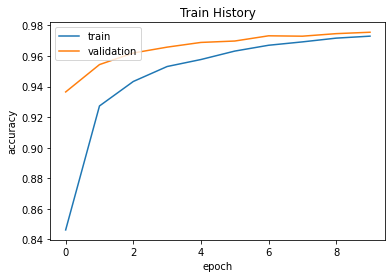

In [18]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train]) #绘制训练数据的执行结果
    plt.plot(train_history.history[validation]) #绘制验证数据的执行结果
    plt.title('Train History') #图标题 
    plt.xlabel('epoch') #x轴标签
    plt.ylabel(train) #y轴标签
    plt.legend(['train','validation'],loc='upper left') #添加左上角图例
 
show_train_history(train_history,'accuracy','val_accuracy')

**六.模型的测试**


1.我们通过evaluate可以使用模型在测试集上进行测试。



In [19]:
scores = model.evaluate(X_test_normalize,y_TestOneHot) 
print('accuracy=',scores[1]) #显示测试准确率

313/313 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9775
accuracy= 0.9775000214576721


2.对模型进行预测，并使用之前我们定义的函数plot_image_labels_prediction，可以方便查看预测结果之间的对应关系。



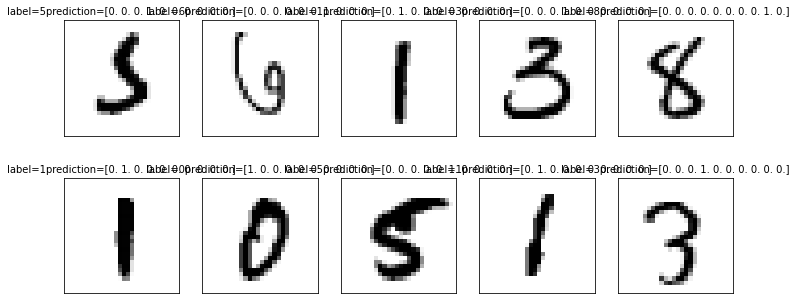

In [20]:
prediction = model.predict(X_test) #结果预测
plot_image_labels_prediction(X_test_image,y_test_label,prediction,idx=340)

3.我们还可以通过pandas中的crosstab调用混淆矩阵，来查看哪些结果最容易混淆，对角线部分，为正确预测的部分，其它部分则是预测错误的部分。



使用pandas的crosstab函数查看混淆矩阵。这里要注意的是pandas.crosstab的输入必须是一维数组，所以传入的prediction和测试集的label都需要是一维的，如果不是一维数组，需要用reshape转为一维数组。


In [21]:
import numpy as np
prediction=np.argmax(prediction,axis=1)

In [22]:
print(prediction.shape)
print(y_test_label.shape)

(10000,)
(10000,)


In [23]:
pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,968,0,1,2,0,0,4,1,3,1
1,0,1119,4,1,0,0,3,0,8,0
2,4,0,1004,3,2,0,2,6,11,0
3,1,0,6,990,0,2,0,4,6,1
4,1,0,4,0,957,0,4,2,2,12
5,2,0,0,15,2,852,8,1,9,3
6,4,3,0,1,2,3,943,0,2,0
7,1,6,14,2,0,0,0,994,1,10
8,2,0,1,6,3,1,1,4,955,1


4.我们还可以通过pandas的DataFrame来查看预测错误数据的位置。



In [24]:
df = pd.DataFrame({'label':y_test_label,'predict':prediction})
print(df[(df.label==5)&(df.predict==3)]) #查看是5预测错成3的数据位置

      label  predict
340       5        3
1003      5        3
1393      5        3
2035      5        3
2810      5        3
3702      5        3
3902      5        3
4271      5        3
4360      5        3
5937      5        3
5972      5        3
6598      5        3
6706      5        3
8160      5        3
9482      5        3


或者通过我们先前定义的plot_image_labels_prediction函数，也可以直接查看预测错误的图像。



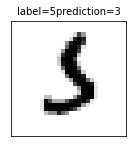

In [25]:
plot_image_labels_prediction(X_test_image,y_test_label,prediction,idx=340,nums=1)


以上便是Keras第一个实例的操作内容，该实例比较完整的演示了一个简单数据集在训练、测试及预测的整体流程，过段时间会分享后续的系列内容。